<a href="https://colab.research.google.com/github/fowardelcac/Keras-FreeCodeCamp/blob/main/b_CNN_dogsVScats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools, os, shutil, random, glob, warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

import kagglehub

# Download latest version
path = kagglehub.dataset_download("salader/dogs-vs-cats")

print("Path to dataset files:", path)

100%|██████████| 1.06G/1.06G [00:12<00:00, 93.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1


In [2]:
path = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/"
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

  # Define the new dataset path
new_base_dir = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats_small/"
os.makedirs(new_base_dir, exist_ok=True)

# Create new train and test directories with subdirectories for dogs and cats
for split in ['train', 'valid', 'test']:
    for category in ['dogs', 'cats']:
        os.makedirs(os.path.join(new_base_dir, split, category), exist_ok=True)


def split(new_base_dir, data_dir, name_dir, amount_of_images):
  # Function to copy a subset of images
  def copy_images(source_dir, dest_dir, num_images):
      images = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]
      selected_images = random.sample(images, num_images)
      for img in selected_images:
          shutil.copy(os.path.join(source_dir, img), os.path.join(dest_dir, img))
  copy_images(
      os.path.join(data_dir, 'cats'),
      os.path.join(new_base_dir, name_dir, 'cats'),
      amount_of_images
  )
  copy_images(
      os.path.join(data_dir, 'dogs'),
      os.path.join(new_base_dir, name_dir, 'dogs'),
      amount_of_images
  )


split(new_base_dir, train_dir, 'train', 500)
split(new_base_dir, train_dir, 'valid', 100)
split(new_base_dir, test_dir, 'test', 50)

  # Verify the training set
print("Training set:")
print(f"Cats: {len(os.listdir(os.path.join(new_base_dir, 'train', 'cats')))}")
print(f"Dogs: {len(os.listdir(os.path.join(new_base_dir, 'train', 'dogs')))}")
print("*" * 100)

  # Verify the valid set
print("Validation set:")
print(f"Cats: {len(os.listdir(os.path.join(new_base_dir, 'valid', 'cats')))}")
print(f"Dogs: {len(os.listdir(os.path.join(new_base_dir, 'valid', 'dogs')))}")
print("*" * 100)

# Verify the test set
print("Test set:")
print(f"Cats: {len(os.listdir(os.path.join(new_base_dir, 'test', 'cats')))}")
print(f"Dogs: {len(os.listdir(os.path.join(new_base_dir, 'test', 'dogs')))}")


Training set:
Cats: 500
Dogs: 500
****************************************************************************************************
Validation set:
Cats: 100
Dogs: 100
****************************************************************************************************
Test set:
Cats: 50
Dogs: 50


In [6]:
train_path = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats_small/train"
valid_path = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats_small/valid"
test_path = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats_small/test"

# Format to keras for vgg16 model
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), classes=['dogs', 'cats'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['dogs', 'cats'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
      .flow_from_directory(directory=test_path, target_size=(224, 224), classes=['dogs', 'cats'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [9]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

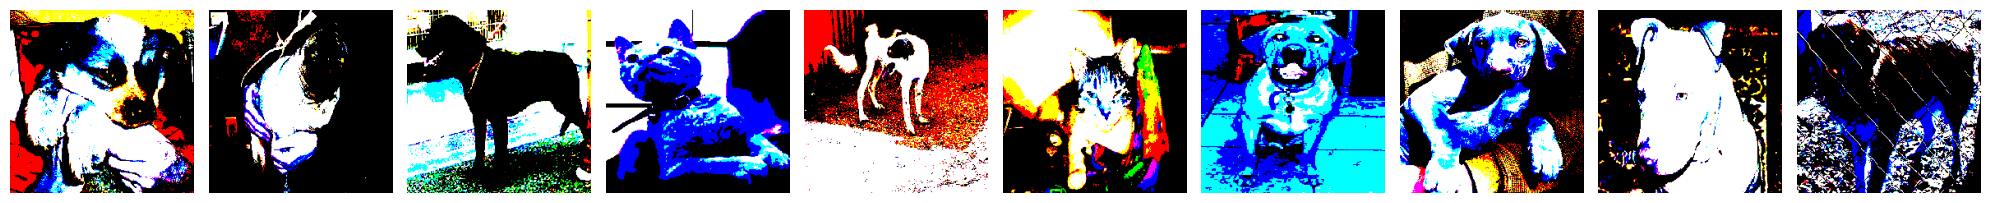

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [14]:
imgs, labels = next(train_batches)

def plotet(images_appr):
  fig, axes = plt.subplots(1, 10, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_appr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

plotet(imgs)
#{'dogs': 0, 'cats': 1}

print(labels)

# Training

In [15]:
model = Sequential([
    #input width*height*rgb
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │         401,410 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
    )
#train batches contain test(due imageGenerator), this is the whay i dont add 'y' param
model.fit(x=train_batches, validation_data=valid_batches, epochs=2, verbose=2)

Epoch 1/2
100/100 - 82s - 824ms/step - accuracy: 0.8480 - loss: 1.7972 - val_accuracy: 0.6450 - val_loss: 2.3642
Epoch 2/2
100/100 - 78s - 785ms/step - accuracy: 0.9580 - loss: 0.1319 - val_accuracy: 0.5950 - val_loss: 2.0492


# Predict

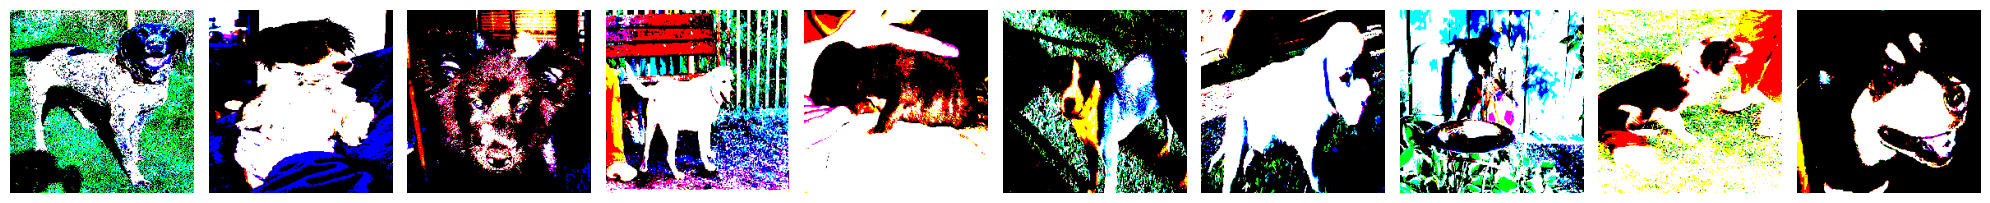

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [18]:
test_imgs, test_labels = next(test_batches)
plotet(test_imgs)
print(test_labels)

In [19]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

i did not shuffled the test data cause i need the exact mapping to check it out the results

In [20]:
predictions = model.predict(x=test_batches, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [22]:
predictions

array([[9.99999583e-01, 4.04223954e-07],
       [3.78220693e-06, 9.99996126e-01],
       [8.16412910e-04, 9.99183595e-01],
       [9.99777794e-01, 2.22293835e-04],
       [5.43926060e-02, 9.45607305e-01],
       [9.80202198e-01, 1.97977629e-02],
       [3.15051002e-04, 9.99684930e-01],
       [9.99997675e-01, 2.32121329e-06],
       [9.99769866e-01, 2.30196631e-04],
       [1.96449906e-02, 9.80355024e-01],
       [1.93246501e-03, 9.98067498e-01],
       [9.99989450e-01, 1.05241515e-05],
       [9.72420037e-01, 2.75799502e-02],
       [9.86102164e-01, 1.38977841e-02],
       [9.99999940e-01, 1.48679905e-11],
       [9.87881422e-01, 1.21185947e-02],
       [9.98219132e-01, 1.78088201e-03],
       [6.43518567e-02, 9.35648143e-01],
       [9.99999762e-01, 2.72095349e-07],
       [4.34740543e-01, 5.65259457e-01],
       [9.99999940e-01, 2.97014913e-10],
       [9.86764193e-01, 1.32357376e-02],
       [2.34497911e-05, 9.99976456e-01],
       [9.99893129e-01, 1.06755033e-04],
       [1.380600

In [21]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [23]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm

array([[35, 15],
       [13, 37]])

In [25]:
def plotet_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
test_batches.class_indices

{'dogs': 0, 'cats': 1}

Confusion matrix, without normalization


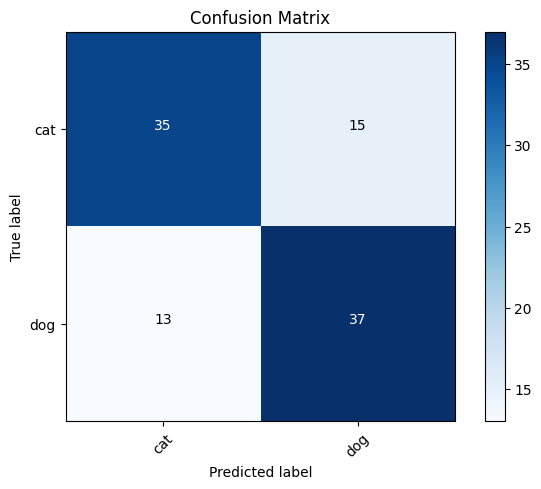

In [29]:
cm_plot_labels = ['cat', 'dog']
plotet_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')